# Current Problem Statement
I am on a gameshow, and the host has an unknown $\vec{x}$. I am trying to uncover that $\vec{x}$. He samples one row $
\vec{w_1}^T=[w_{11}, w_{12}, ..., w_{1n}]$ from the Walsh matrix without replacement and multiplies it with that $\vec{x}$ to get $\vec{y_1}$, which is now a scalar, since he sampled one row. I try to find all $\tilde{x}$ such that $\vec{w_1}\tilde{x}=\vec{y_1}$ is satisfied. I must end up with at most $_{n}C_{k}$ $\tilde{x}$'s, including one that is actually equal to $x$. I keep these all in a pool. Then, the host samples another row, forming the matrix: 

$\hat{W}=\begin{bmatrix}
\vec{w_1}^T \\
\vec{w_2}^T
\end{bmatrix}$

Select the $\tilde{x}$'s from the set we have that are consistent with $\hat{W}{\vec{x}}={\vec{y_2}}$. We should have less than $_{n}C_{k}$ solutions. However, once the host samples $\frac{klog_{2}(N)}{log_{2}(K)}$ rows, we should only have one unique solution, which is the correct $x$. If we don't, this is an unsuccessful run.

Later, develop a deep policy/reinforcement learning network that can cleverly sample rows of the Walsh matrix such that $x$ is uncovered at the optimal time.


# Naive Solution
Below, we check every possible solution to $\hat{W}{\vec{x}}={\vec{y}}$ on each iteration. The computation explodes at around $K=16$.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial, ceil
from tqdm.auto import trange, tqdm

In [2]:
# Helper Functions
def to_binary(n, N):
    """
    Get binary representation of input n

    :param n: Integer of which to get binary representation
    :param N: Length of bitstring
    :return: str
    """
    return bin(n).replace('0b', '').zfill(N)


def get_w_hat_t_helper(row_idx, col_idx, N):
    """
    Helper function to get entry (t, col_idx) of W-H matrix

    :param row_idx: Row index of W-H matrix to find
    :param col_idx: Column index of W-H matrix to find
    :param N: Order of W-H matrix
    :return: int
    """
    row_bin = to_binary(row_idx, N)
    col_bin = to_binary(col_idx, N)

    row_list = [int(row_bit) for row_bit in list(row_bin[::-1])]
    col_list = [int(col_bit) for col_bit in list(col_bin[::-1])]

    result = 0
    for row_bit, col_bit in zip(row_list, col_list):
        result += row_bit * col_bit

    result = int((1 + ((-1) ** result)) / 2)
    return result


def get_x_vector(N, K):
    """
    Return x from given order of WH matrix and K

    :param N: Order of WH matrix
    :param K: Number of ones
    :return: numpy.ndarray
    """
    x = np.zeros(N)
    random_pos = np.random.choice(
        np.arange(0, N), K, replace=False
    )
    x[random_pos] = 1
    return x


def get_w_hat_t(t_idx: int, N):
    """
    Get t-th row of W-H matrix of order _N

    :param t_idx: Index of row in W-H matrix
    :return: list
    """
    row = []
    for i in range(N):
        row.append(get_w_hat_t_helper(t_idx, i, N))

    return row


def get_all_1_k_vectors(N, K):
    vector = [1] * K + [0] * (N - K)
    return list(set(itertools.permutations(vector, N)))


def check_x_set(all_x, A, b):
    valid_x = set()
    for x_vector in all_x:
        if (A @ x_vector == b).all():
            valid_x.add(tuple(x_vector))  # Make x-vectors immutable

    return list(valid_x)


def recover_x_naive(N, K):
    W = np.array([get_w_hat_t(i, N) for i in range(N)])
    x = get_x_vector(N, K)
    # print(f'x = {x}')

    row_pos = np.random.choice(np.arange(0, N), N, replace=False)

    # First row sampling
    W_hat = W[row_pos[0]]
    y = W_hat @ x
    all_x = get_all_1_k_vectors(N, K)
    valid_solutions = check_x_set(all_x, W_hat, y)
    num_solutions = [len(valid_solutions)]
    iteration_found = []

    for i, row_idx in enumerate(row_pos[1:]):
        # Oracle samples row
        W_hat = np.vstack((W_hat, W[row_idx]))
        y = W_hat @ x
        # print(f'y_{i + 2} = {y}')
        valid_solutions = check_x_set(valid_solutions, W_hat, y)
        if len(valid_solutions) == 1:
            iteration_found.append(i + 2)
        num_solutions.append(len(valid_solutions))

    x_tilde = []
    optimum_found = N

    # If x was successfully recovered
    if len(valid_solutions) == 1:
        x_tilde = list(valid_solutions[0])
        optimum_found = iteration_found[0]

    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.plot(num_solutions, lw=0.3, c='black')
    plt.ylabel('Number of Solutions')
    plt.xlabel('Number of Iterations')
    plt.axvline(opt, c='r')

    return x_tilde, optimum_found


def plot_recover_x_trials(n, N, K):
    plt.figure(figsize=(8, 6))
    n_perms = int(factorial(N) / factorial(N - K))
    print(f'Number of possible x vectors: {n_perms}')
    iteration_found = []
    for i in tqdm(range(n)):
        x, it = recover_x_naive(N, K)
        iteration_found.append(it)
    plt.title(f'{n} Trials: N = {N}, K = {K}', fontsize=18)
    plt.figure(figsize=(8, 4))
    sns.distplot(iteration_found, color='black', hist_kws={'rwidth':0.75})
    opt = ceil(K * np.log2(N) / np.log2(K))
    plt.axvline(opt, c='r')
    plt.title(f'Iterations Found Unique Solution Over {n} Trials', fontsize=18)
    plt.xlabel('Iteration Number')
    plt.ylabel('Frequency')
    print(f'Actual optimal iteration: {opt}')
    print(f'Mean optimal iteration: {np.mean(iteration_found)}')

# plot_recover_x_trials(50, 8, 3)

# Faster Solution
The host gives us $\vec{y}=[y_1,...,y_{logN}]$. Let $s_1,...,s_k$ be the indices of 1 in $\vec{x}$. Given these locations, we can derive $\tilde{W}_{logN\times N}$. We multiply $\vec{x}$ by $\tilde{W}$ to get $\vec{y}$.

We want to get the $logN$ rows of the Walsh matrix that are associated with the binary expansion of each $s_i, i\in{0,...,N-1}$. This is how we derive $\tilde{W}$.

Let $\sum_{i=1}^{k}s_i=$ scalar form of $\vec{y}=\sum_{i=0}^{logN} y_i * 2^i$, from the scalar form of $\vec{y}$. We will know what all of the locations of the nonzero elements of $\vec{x}$ add up to. Thus, we receive all options for $\vec{x}$ that satisfy $W\vec{x}=\vec{y}$. This amount of solutions will be the number of ways to add up to sum of all positions of nonzero elements in $\vec{x}$.

In [33]:
np.random.seed(0)


def gen_W_tilde(N):
    """
    Generate W_(logN x N) with binary expansions of locations
    """
    W_tilde = np.empty((int(np.log2(N)), 0))
    for i in range(N):
        binary_str = str(to_binary(i, int(np.log2(N))))[::-1]
        list_binary_str = ([int(bit) for bit in binary_str])
        W_tilde = np.column_stack((W_tilde, list_binary_str))
    return W_tilde


def scalar(y):
    """
    Compute scalar value: Y = \sum {2^i * y_i}
    """
    return int(sum([2 ** i * y_i for i, y_i in enumerate(y)]))


def get_W_tilde_rows(W, W_tilde):
    """
    Find rows of W_tilde within the Walsh-Hadamard matrix
    """
    W_tilde_bits = [list(reversed(row)) for row in W_tilde]
    W_idx = [np.where(np.all(W == row, axis=1))[0][0] for row in W_tilde_bits]
    return W_idx


def sum_to_S(n, k):
    """
    Helper function to return all ways for k numbers to sum up to S
    """
    solutions = []
    for comb in itertools.combinations(range(n + k - 1), k - 1):
        s = [comb[0]]
        for i in range(1, k - 1):
            s.append(comb[i] - comb[i - 1] - 1)
        s.append(n + k - 2 - comb[k - 2])
        solutions.append(s)
    return solutions


def get_solutions(N, K, W_tilde, x):
    """
    
    """
    # Scalar form of y = W_tilde * x
    S = scalar(W_tilde @ x)
    print(f'Scalar value = {S}')
    solutions = []
    for partition in sum_to_S(S, K):
        if len(set(partition)) == len(partition) and max(partition) < N:
            partition = sorted(partition)
            if partition not in solutions:
                solutions.append(partition)
    x_vectors = []
    for sol in solutions:
        tmp = np.zeros(N)
        tmp[sol] = 1
        x_vectors.append(tmp)
    return x_vectors


def sample_remaining(N, K, W, W_tilde, x, n_rows=1, logging=True):
    # Rows of W_tilde, to remove from W
    to_remove = get_W_tilde_rows(W, W_tilde)
    W = np.delete(W, to_remove, 0)
    valid_solutions = get_solutions(N, K, W_tilde, x)
    curr_n_solutions = [len(valid_solutions)]
    if logging:
        print(f'Initial possible solutions: {len(valid_solutions)}')
    y = W_tilde @ x
    for i in range(n_rows - 1):
        if len(W) == 0:
            if logging:
                print('No solution found.')
            break
        if logging:
            print(f'ITERATION #{int(np.log2(N) + i + 1)}')
            print('---------------')
        random_idx = np.random.choice(len(W), replace=False)
        sampled_row = W[random_idx]
        W = np.delete(W, random_idx, 0)
        W_tilde = np.append(W_tilde, [sampled_row], 0)
        if logging:
            print(f'# measurements: {len(W_tilde)}')
        y = W_tilde @ x
        valid_solutions = [
            list(map(int, x)) for x in (check_x_set(valid_solutions, W_tilde, y))
        ]
        if len(valid_solutions) != 1:
            if logging:
                print(f'{len(valid_solutions)} solutions left')
                for s in valid_solutions:
                    print(s)
                print('\n')
            curr_n_solutions.append(len(valid_solutions))
        else:
            if logging:
                print(f'CORRECT SOLUTION: {valid_solutions[0]}')
                print(W_tilde)
            curr_n_solutions.append(1)
            break
    if curr_n_solutions[0] == 1:
        curr_n_solutions = [1]
    if logging:
        print(f'Number of solutions on each iteration: {curr_n_solutions}')
    return curr_n_solutions


In [54]:
np.random.seed(0)

N = 8
K = 2
W_tilde = gen_W_tilde(N)
W = np.array([get_w_hat_t(i, N) for i in range(N)])
x = get_x_vector(N, K)
n_rows = N
# print(f'-----------W-Tilde-----------\n{W_tilde}\n')
# print(f'-----------Walsh-Hadamard-----------\n{W}\n')
# print(f'-----------x-----------\n{x}\n')

sample_remaining(N, K, W, W_tilde, x, n_rows)

Scalar value = 8
Initial possible solutions: 3
ITERATION #4
---------------
# measurements: 4
CORRECT SOLUTION: [0, 0, 1, 0, 0, 0, 1, 0]
[[0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 0. 1.]]
Number of solutions on each iteration: [3, 1]


[3, 1]

Scalar value = 3
Scalar value = 7
Scalar value = 4
Scalar value = 11
Scalar value = 7
Scalar value = 9
Scalar value = 5
Scalar value = 10
Scalar value = 11
Scalar value = 8
Scalar value = 8
Scalar value = 1
Scalar value = 9
Scalar value = 7
Scalar value = 13
Scalar value = 11
Scalar value = 13
Scalar value = 6
Scalar value = 7
Scalar value = 9
Scalar value = 7
Scalar value = 5
Scalar value = 6
Scalar value = 5
Scalar value = 8
Scalar value = 6
Scalar value = 2
Scalar value = 6
Scalar value = 11
Scalar value = 7
Scalar value = 10
Scalar value = 3
Scalar value = 5
Scalar value = 10
Scalar value = 1
Scalar value = 6
Scalar value = 10
Scalar value = 6
Scalar value = 9
Scalar value = 13
Scalar value = 12
Scalar value = 3
Scalar value = 10
Scalar value = 6
Scalar value = 6
Scalar value = 4
Scalar value = 11
Scalar value = 9
Scalar value = 6
Scalar value = 8


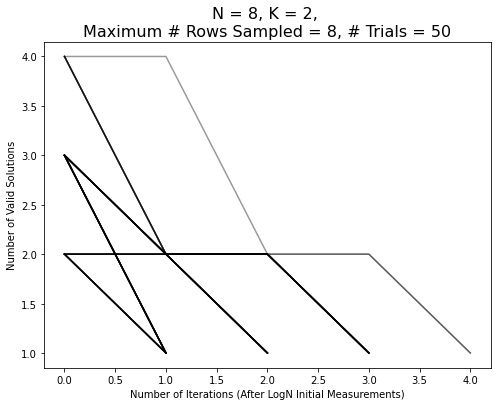

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


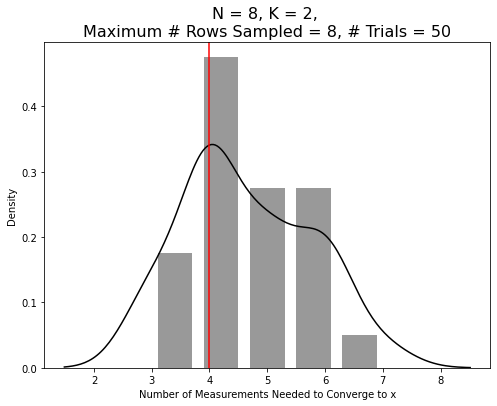

In [61]:
def run_experiments(N, K, n_rows, n_exp=50):
    plt.figure(figsize=(8, 6))
    results = []
    opt = ceil(K * np.log2(N) / np.log2(K + 1))  # Optimistic measure
    for _ in range(n_exp):
        W_tilde = gen_W_tilde(N)
        W = np.array([get_w_hat_t(i, N) for i in range(N)])
        x = get_x_vector(N, K)
        # x = [0, 0, 0, 1, 0, 0, 0, 1]
        res = sample_remaining(N, K, W, W_tilde, x, n_rows, logging=False)
        plt.plot(res, c='k', alpha=0.4)
        results.append(res)
    
    plt.xlabel('Number of Iterations (After LogN Initial Measurements)')
    plt.ylabel('Number of Valid Solutions')
    plt.title(f'N = {N}, K = {K}, \nMaximum # Rows Sampled = {n_rows}, # Trials = {n_exp}', fontsize=16)
    plt.show()
    plt.figure(figsize=(8, 6))
    sns.distplot([len(res) + np.log2(N) - 1 for res in results], color='black', hist_kws={'rwidth':0.75})
    plt.xlabel('Number of Measurements Needed to Converge to x')
    plt.axvline(x=opt, c='r')
    plt.title(f'N = {N}, K = {K}, \nMaximum # Rows Sampled = {n_rows}, # Trials = {n_exp}', fontsize=16)
    # return results

run_experiments(8, 2, 8)

In [60]:
# TODO: FIX FOR K = 1